# Day 7

### BUSI 520: Python for Business Research
### Kerry Back, JGSB, Rice University

### Outline 

- Some overview of ML
- Decision trees
- Random forests and gradient boosting 
- Classifiers 
- Start with toy data and then some sklearn datasets

### Some ML Models

- Linear (OLS, lasso, ridge, elastic net) -- Monday 
- Trees (decision trees, random forests, gradient boosting) -- Today
- Neural networks -- in two weeks
- Support vector machines, k-nearest neighbors, etc.

### Which model is best?

- Linear models are best if you know the data are linear.
- In general, imposing parametric assumptions is useful when you don't have much data.
- Trees are more flexible.
- Neural networks can approximate any functional relationship.

### Some terminology

- Bagging = bootstrap aggregation
  - bootstrap means to sample from the data with replacement to create random samples 
  - aggregation means to average the predictions of many models
  - Random forests are an example of bagging
- Boosting = train a sequence of models where each model tries to correct the errors of the previous model
  - Gradient boosting is an example
- Goal of bagging and boosting is to combine many weak learners to create a strong learner
- Regression in ML = prediction of a continuous variable
- Classification in ML = prediction of a categorical variable

### Decision trees

- Random forests and gradient boosting are based on decision trees
- A decision tree starts with a yes or no question.  
  - Depending on the answer, there is another yes or no question.
  - Each question is of the form: Is variable $x_i$ greater than threshold $t_i$?
  - The tree ends in a leaf node that gives the prediction.
- In regression, the tree is grown by choosing the variable and threshold that minimizes the MSE at the next step.

### Example 

![](images/Trees_Transparent.png)

### Random data

- 10 features
- target is product of first two plus noise
- 1,500 observations (1,000 training, 200 validation, 300 test)

In [75]:
import numpy as np 

np.random.seed(0)  # just so we all get the same results

# full hypothetical sample 
X = np.random.normal(size=(1500, 10))
y = X[:, 0] * X[:, 1] + np.random.normal(size=1500)

# randomly split into training and test samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=300
)
X_train0, X_val, y_train0, y_val = train_test_split(
    X_train, y_train, test_size=200
)

### Train a decision tree

- We will use a max depth of 3 for illustration.
- We will train on (X_train0, y_train0).

In [76]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=3)
model.fit(X_train0, y_train0)

DecisionTreeRegressor(max_depth=3)

### View the tree

- We do this only for illustration.

In [77]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

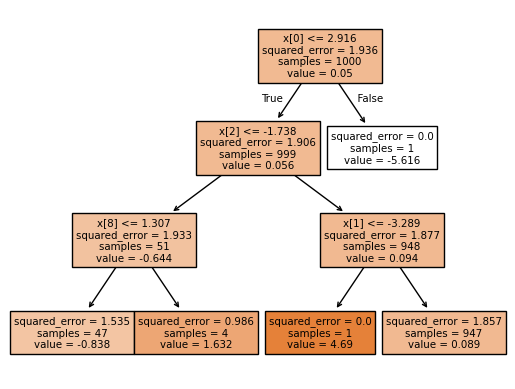

In [78]:
plot_tree(model, filled=True)
plt.show()

### Random forest 

- Bootstrap samples are used to create random datasets.
- A tree is fit to each random dataset.
- Average predictions of all trees to get the final prediction (for regression)
  - Can choose a random subset of $n$ features at each split to select from. 
- Key hyperparameters are n_estimators, max_features, and max_depth.

### Gradient boosting

- Fit a decision tree.
- Look at its errors.  Fit a new decision tree to predict the errors.
- Add a fraction (learning rate) of the error prediction to get a new prediction.
- Continue ...
- Key hyperparameters are n_estimators, learning_rate, and max_depth.
- Probably want to use xgboost library (eXtreme Gradient Boosting).

### Overfitting / underfitting 

- Decision trees can overfit if we allow them to grow too deep. 
- If they are too shallow, they will underfit.
- In general,
  - Model too complex or not sufficiently regularized (penalized) -> overfit 
  - Model too simple or too regularized -> underfit

### Random forest example

In [79]:
from sklearn.ensemble import RandomForestRegressor 

# train and validate
depths = range(2, 22, 2)
train_scores = []
val_scores = []
for depth in depths:
    model = RandomForestRegressor(max_depth=depth)
    model.fit(X_train0, y_train0)
    train_scores.append(model.score(X_train0, y_train0))
    val_scores.append(model.score(X_val, y_val))

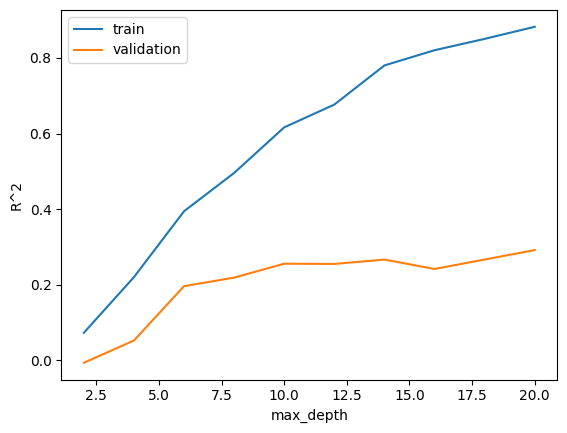

In [80]:
# plot results

import matplotlib.pyplot as plt
plt.plot(depths, train_scores, label='train')
plt.plot(depths, val_scores, label='validation')
plt.xlabel('max_depth')
plt.ylabel('R^2')
plt.legend()
plt.show()

In [81]:
# Diebold-Mariano test 

from dieboldmariano import dm_test

benchmark_predict = np.repeat(y_test.mean(), len(y_test))
best_depth = depths[np.argmax(val_scores)]
model = RandomForestRegressor(max_depth=best_depth)
model.fit(X_train, y_train)  # fit using all data other than test data
model_predict = model.predict(X_test)
dm_test(y_test, model_predict, benchmark_predict, one_sided=True)

(np.float64(-5.814890768275992), np.float64(7.784652577665882e-09))

### Feature importances

- In linear models with standardized right-hand side variables, the coefficients give the importance of each variable.
- In decision trees, we can look at the feature importances, which tell us which features are used the most for splitting.

In [82]:
model.feature_importances_

array([0.27893596, 0.28527914, 0.0710107 , 0.05339588, 0.04650545,
       0.05839854, 0.04809928, 0.05846844, 0.05056529, 0.04934132])

### Gradient boosting example with cross validation

In [83]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

depths = range(2, 12, 2)
learning_rates = [0.1, 0.01, 0.001]
cv = GridSearchCV(
    XGBRegressor(), 
    {'max_depth': depths, 'learning_rate': learning_rates}
)

# use all of our training data for cross-validation
cv.fit(X_train, y_train)

# test on test data 
print(f"R2 on test data is {cv.score(X_test, y_test)}")

# see best hyperparameters
print(f"\nbest hyperparameters are {cv.best_params_}")

# feature importances
print(f"\nfeature importances are {cv.best_estimator_.feature_importances_}")

R2 on test data is 0.387006955062173

best hyperparameters are {'learning_rate': 0.1, 'max_depth': 6}

feature importances are [0.15721264 0.22603351 0.07810193 0.06738326 0.06656754 0.07817706
 0.07429293 0.09016509 0.08388416 0.07818186]


### Classification

- Binary or multi-class
- Can use lasso or ridge versions of logistic regression
- Tree-based classifiers use same syntax as regressors.  Generally same hyperparameters.
- Same issues with overfitting and underfitting.  Can use cross validation to choose hyperparameters as in the regression case.
- One difference is goodness of fit measure.  
  - Regression usually uses MSE (but can use MAE).  
  - Classification uses accuracy, precision, recall, F1 score, etc.

### Goodness of fit in binary classification 

- Accuracy = % correct 
- Precision = % of positive predictions that are correct
- Recall = % of actual positives that are predicted correctly
- F1 score = harmonic mean of precision and recall (harmonic mean = reciprocal of average reciprocal).
- Example: cancer screening
  - Precision = % of people who test positive who actually have cancer
  - Recall = % of people who have cancer who test positive
  - F1 score = balance between the two

### Predicting probabilities

- Classifiers actually predict probabilities of being in each class.
- Probabilities are by default converted to class predictions as: highest probability class is the prediction.
- Can use other thresholds to convert probabilities to class predictions.
- Example: cancer screening
  - If we want to catch all cases of cancer, we might set a low threshold.
  - If we want to be very sure that a positive test is correct, we might set a high threshold.

### Impurity

- In tree models, prediction is most dominant class in each leaf node.
  - Choose splits to minimize impurity (Gini or entropy) rather than MSE.
  - Pure means all observations in a node are of the same class.
- With $k$ classes, the Gini impurity of a group of observations is 
$$ 1 - \sum_{i=1}^k p_i^2 $$
  - $p_i$ is the fraction of the observations that are in class $i$.
  - Perfect purity (all in 1 class) -> Gini impurity = 0
  - Equal fraction in all classes -> Gini impurity = $1 - 1/k$

In [84]:
### Revised random data 

import numpy as np 

np.random.seed(0)  # just so we all get the same results

# full hypothetical sample 
X = np.random.normal(size=(1500, 10))
y = X[:, 0] * X[:, 1] + np.random.normal(size=1500)

# classify into three categories
y = np.select([y < -1, np.abs(y) <= 1, y > 1], [0, 1, 2])

# randomly split into training and test samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=300
)
X_train0, X_val, y_train0, y_val = train_test_split(
    X_train, y_train, test_size=200
)

### Decision tree classifier

In [85]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train0, y_train0)

DecisionTreeClassifier(max_depth=3)

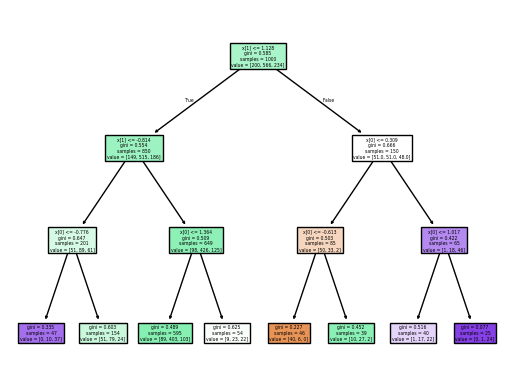

In [86]:
plot_tree(model, filled=True)
plt.show()

### Random forest classifier

In [87]:
from sklearn.ensemble import RandomForestClassifier

depths = range(2, 22, 2)
cv = GridSearchCV(
    RandomForestClassifier(), 
    {'max_depth': depths}
)

# use all of our training data for cross-validation
cv.fit(X_train, y_train)

# test on test data 
print(f"accuracy on test data is {cv.score(X_test, y_test)}")

# see best hyperparameters
print(f"\nbest hyperparameters are {cv.best_params_}")

# feature importances
print(f"\nfeature importances are {cv.best_estimator_.feature_importances_}")

accuracy on test data is 0.63

best hyperparameters are {'max_depth': 16}

feature importances are [0.16687997 0.17617539 0.08728818 0.07671825 0.08247482 0.08678349
 0.0756431  0.08334694 0.08370289 0.08098698]


### More on GridSearchCV

- After running it, the model is automatically fit on all of the (training) data using the best parameters.
- Then methods of models are available: .predict, .score, .feature_importances_, .best_params_, .predict_proba, etc.

In [88]:
# probabilities from the best hyperparameters 

cv.predict_proba(X_test)

array([[0.04252002, 0.44427695, 0.51320303],
       [0.04249497, 0.87481507, 0.08268996],
       [0.12707821, 0.52913918, 0.34378261],
       [0.09113424, 0.72451944, 0.18434631],
       [0.58857143, 0.30142857, 0.11      ],
       [0.15671429, 0.34228571, 0.501     ],
       [0.11639415, 0.73950915, 0.14409669],
       [0.1565243 , 0.60216749, 0.24130821],
       [0.59      , 0.28      , 0.13      ],
       [0.17531217, 0.64575661, 0.17893122],
       [0.19419812, 0.3946142 , 0.41118768],
       [0.35663919, 0.44286943, 0.20049138],
       [0.24278765, 0.63447316, 0.12273919],
       [0.46      , 0.32591837, 0.21408163],
       [0.32491067, 0.41662124, 0.25846809],
       [0.06      , 0.54      , 0.4       ],
       [0.23504135, 0.40430821, 0.36065045],
       [0.14987966, 0.6896587 , 0.16046165],
       [0.23369048, 0.54793651, 0.21837302],
       [0.04459183, 0.54819218, 0.40721599],
       [0.08584211, 0.8200559 , 0.09410199],
       [0.41106679, 0.43013389, 0.15879932],
       [0.

### Confusion matrix and ROC curve

- Confusion matrix is a table of actual vs. predicted classes.  Reveals where the errors are.
- ROC curve is a plot of true positive rate vs. false positive rate for different thresholds of the predicted probabilities.
  - Used for binary classification.  Can extend to multiclass by creating dummies.
  - AUC is the Area Under the (ROC) Curve.  AUC = 1 is perfect, AUC = 0.5 is random.
  - Useful for picking an optimal threshold, given a model.

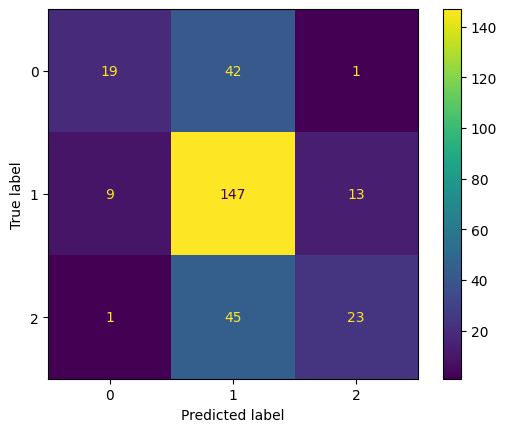

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    estimator=cv, 
    X=X_test, 
    y=y_test
)
plt.show()

### Binary classification example 

- Target = dummy for y > 0

In [90]:
### Second revision of data 

import numpy as np 

np.random.seed(0)  # just so we all get the same results

# full hypothetical sample 
X = np.random.normal(size=(1500, 10))
y = X[:, 0] * X[:, 1] + np.random.normal(size=1500)

# classify into two categories
y = 1 * (y > 0)

# randomly split into training and test samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=300
)
X_train0, X_val, y_train0, y_val = train_test_split(
    X_train, y_train, test_size=200
)

In [91]:
# exact same code as for multi-class classification

depths = range(2, 22, 2)
cv = GridSearchCV(
    RandomForestClassifier(), 
    {'max_depth': depths}
)

# use all of our training data for cross-validation
cv.fit(X_train, y_train)

# test on test data 
print(f"accuracy on test data is {cv.score(X_test, y_test)}")

# see best hyperparameters
print(f"\nbest hyperparameters are {cv.best_params_}")

# feature importances
print(f"\nfeature importances are {cv.best_estimator_.feature_importances_}")

accuracy on test data is 0.61

best hyperparameters are {'max_depth': 10}

feature importances are [0.15459823 0.14353626 0.0949279  0.08389458 0.08679904 0.09218103
 0.08275622 0.09064638 0.08656148 0.08409889]


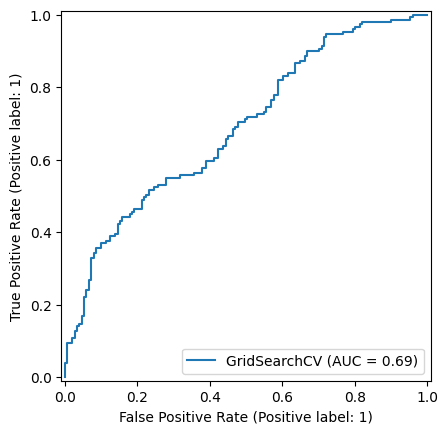

In [92]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(
    estimator=cv, 
    X=X_test, 
    y=y_test, 
)
plt.show()

### Saving models

To save a trained model so you can use it again without training again, use joblib.dump(model, 'filename').

    import joblib
    joblib.dump(model, 'filename')

or 
    
        from joblib import dump
        dump(model, 'filename')

In [93]:
# saving 

from joblib import dump
dump(cv, 'mymodel.joblib')

['mymodel.joblib']

In [94]:
# loading and reusing

from joblib import load
cv = load('mymodel.joblib')
cv.predict(X_test)

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0])

### Ask Julius 

- Get the California house price data, run random forest regressor on it, and show the feature importances.
- Get the digits data, show the images, run a classifier on it, and show the confusion matrix.
- Get the breast cancer data, run a classifier on it, and show the confusion matrix and ROC curve.